# CIFAR 10 Convolutional Neural Network

# Check for CUDA

In [1]:
import torch
import numpy as np

# check for CUDA
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


# Grab Data

In [2]:
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler

# subprocesses for dataloading
num_workers = 0

# samples per batch
batch_size = 20

# Validation set size in percent
valid_size = 0.2

# normalize data
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# Load data
train_data = datasets.CIFAR10("data", train=True, download=True, transform=transform)
test_data = datasets.CIFAR10("data", train=False, download=True, transform=transform)

# split data
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size*num_train))
train_idx, valid_idx = indices[split:], indices[:split]

#define samplers
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# prepare data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, sampler=valid_sampler, num_workers=num_workers)

test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, num_workers=num_workers)

# specify the image classes
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']

0it [00:00, ?it/s]

170500096it [00:04, 41981462.50it/s]                               


Files already downloaded and verified


# Visualize

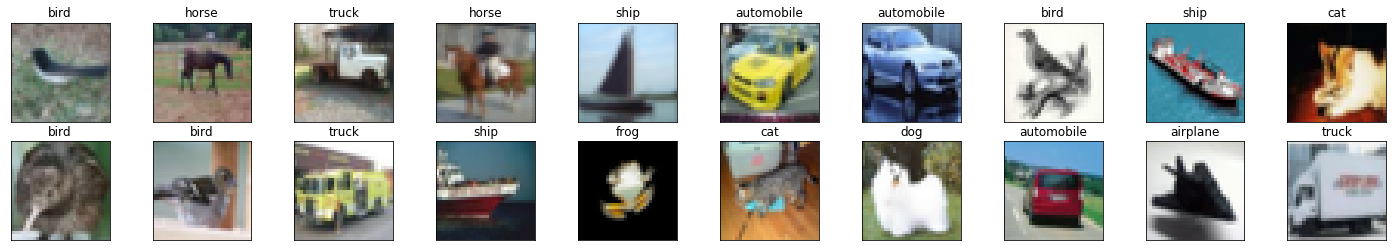

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

# helper function to un-normalize and display an image
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image

# obtain a batch
images, labels = iter(train_loader).next()
images = images.numpy()

#plot
fig = plt.figure(figsize=(25,4))
for idx in np.arange(batch_size):
  ax = fig.add_subplot(2, batch_size/2, idx+1, xticks=[], yticks=[])
  imshow(images[idx])
  ax.set_title(classes[labels[idx]])

# Define the Network Architecture

In [0]:
import torch.nn as nn
import torch.nn.functional as F

# define the CNN Architecture
class Network(nn.Module):
  def __init__(self):
    super().__init__()
    
    # convolutional layer (input = 32x32x3 image tensor)
    self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
    
    # convolutional layer (input = 16x16x16)
    self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
    
    # convolutional layer (input = 8x8x32)
    self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
    
    # Max pooling layer
    self.pool = nn.MaxPool2d(2, 2)
    
    # Fully connected layer (4x4x64 -> 500)
    self.fc1 = nn.Linear(64*4*4, 500)
    
    # Fully connected layer (500 -> 10)
    self.fc2 = nn.Linear(500, 10)
    
    # dropout layer
    self.dropout = nn.Dropout(0.25)
    
  def forward(self,x):
    
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    x = self.pool(F.relu(self.conv3(x)))
    
    # flatten
    x = x.view(-1, 64*4*4)
    
    # add dropout layer
    x = self.dropout(x)
    
    # add hidden layer
    x = F.relu(self.fc1(x))
    
    # add dropout layer
    x = self.dropout(x)
    
    # add output layer
    x = self.fc2(x)
    
    return x

In [11]:
model = Network()
model

Network(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1024, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
  (dropout): Dropout(p=0.25)
)

In [0]:
# move tensors to GPU if CUDA is available
if train_on_gpu:
  model.cuda()

In [0]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(model.parameters(), lr=0.01)

# Train the Network

In [19]:
num_epochs = 25

valid_loss_min = np.Inf

for epoch in range(num_epochs):
  
  train_loss = 0.0
  valid_loss = 0.0
  
  # train the model
  model.train()
  
  for images, labels in train_loader:
    
    # move tensors to gpu
    if train_on_gpu:
      images,labels = images.cuda(), labels.cuda()
      
    # clear gradients
    optimizer.zero_grad()
    
    output = model(images)
    
    # loss
    loss = criterion(output, labels)
    
    # back prop
    loss.backward()
    
    # update weights
    optimizer.step()
    
    # update loss
    train_loss += loss.item()
    
  # validate the model
  model.eval()
  
  for images,labels in valid_loader:
    
    if train_on_gpu:
      images, labels = images.cuda(), labels.cuda()
      
    output = model(images)
    
    loss = criterion(output, labels)
    
    valid_loss += loss.item()
    
  # calculate average losses
  train_loss = train_loss/len(train_loader.sampler)
  valid_loss = valid_loss/len(valid_loader.sampler)
        
  # print training/validation statistics 
  print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))
    
  # save model if validation loss has decreased
  if valid_loss <= valid_loss_min:
      print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
      valid_loss_min,
      valid_loss))
      torch.save(model.state_dict(), 'model_cifar.pt')
      valid_loss_min = valid_loss

Epoch: 0 	Training Loss: 0.000000 	Validation Loss: 0.065747
Validation loss decreased (inf --> 0.065747).  Saving model ...
Epoch: 1 	Training Loss: 0.000000 	Validation Loss: 0.062174
Validation loss decreased (0.065747 --> 0.062174).  Saving model ...
Epoch: 2 	Training Loss: 0.000000 	Validation Loss: 0.057926
Validation loss decreased (0.062174 --> 0.057926).  Saving model ...
Epoch: 3 	Training Loss: 0.000000 	Validation Loss: 0.053781
Validation loss decreased (0.057926 --> 0.053781).  Saving model ...
Epoch: 4 	Training Loss: 0.000000 	Validation Loss: 0.051440
Validation loss decreased (0.053781 --> 0.051440).  Saving model ...
Epoch: 5 	Training Loss: 0.000000 	Validation Loss: 0.049938
Validation loss decreased (0.051440 --> 0.049938).  Saving model ...
Epoch: 6 	Training Loss: 0.000000 	Validation Loss: 0.046103
Validation loss decreased (0.049938 --> 0.046103).  Saving model ...
Epoch: 7 	Training Loss: 0.000000 	Validation Loss: 0.045607
Validation loss decreased (0.04610

In [20]:
model.load_state_dict(torch.load('model_cifar.pt'))


IncompatibleKeys(missing_keys=[], unexpected_keys=[])

# Test the Network

In [21]:
# track test loss
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model.eval()
# iterate over test data
for data, target in test_loader:
    # move tensors to GPU if CUDA is available
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the batch loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)    
    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    # calculate test accuracy for each object class
    for i in range(batch_size):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# average test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.722608

Test Accuracy of airplane: 83% (830/1000)
Test Accuracy of automobile: 88% (885/1000)
Test Accuracy of  bird: 61% (616/1000)
Test Accuracy of   cat: 55% (553/1000)
Test Accuracy of  deer: 70% (700/1000)
Test Accuracy of   dog: 65% (657/1000)
Test Accuracy of  frog: 82% (828/1000)
Test Accuracy of horse: 82% (822/1000)
Test Accuracy of  ship: 84% (840/1000)
Test Accuracy of truck: 82% (821/1000)

Test Accuracy (Overall): 75% (7552/10000)
